In [10]:
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 92.5 MB/s eta 0:00:00


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import interp1d
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": 'cm',  # Computer Modern font - looks like LaTeX
    "font.family": 'STIXGeneral'
})

# Set up colorblind palette for the 4 different plot sets
palette = sns.color_palette("colorblind", 4)
color_tune_damping = palette[0]  # First set (tune_damping)
color_mu02 = palette[1]         # Second set (mu02)
color_mu08 = palette[2]         # Third set (mu08)
color_mu005 = palette[3]        # Fourth set (mu005)


# $ \langle F^{\rm drag} \rangle_{T_{\rm orbit}}$ v.s. n_cell (convergence test)

T_orbit =  869.7963420350058
20250620_tune_damping_n256_1
20250621_tune_damping_n192
20250621_tune_damping_n128


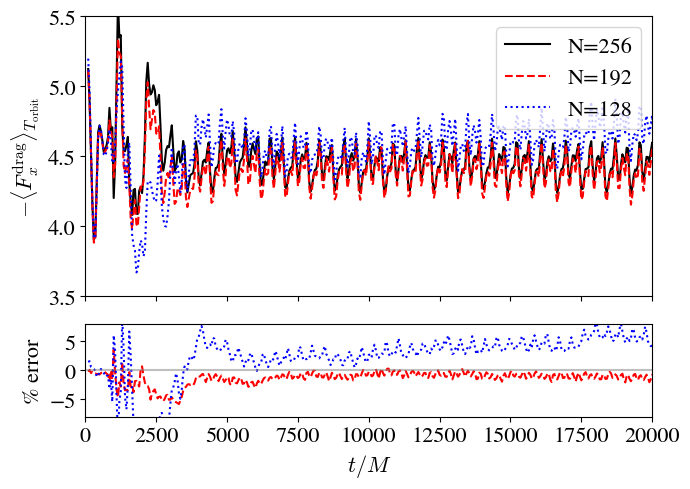

In [2]:
simnames = [ 
    # (640,'250528_BBH_r70_moreplots_restart'),
    (256, '20250620_tune_damping_n256_1'),
    (192, '20250621_tune_damping_n192'),
    (128, '20250621_tune_damping_n128')
]

plotstyles = [
    # ('-.', 'g'),
    ('-', 'k'),
    ('--', 'r'),
    (':', 'b')
]

outR=100.0
excise_factor = 1.5
average_rho_after = 7000.0



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega) 

print("T_orbit = ", T_orbit)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"


fig_fontsize = 16

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Dictionary to store data for each simulation
sim_data = {}

# First plot: drag force
for (ncell, simname), plotstyle in zip(simnames, plotstyles):
    print(simname)
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_drag = np.zeros_like(results[:,1])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
    smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window

    # Calculate normalized drag
    
    # # normalize by mean density
    #avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    # normalized_drag = -smoothed_drag/avgrho
    
    # normalize by density at different times
    normalized_drag = -smoothed_drag/results_sur[:,10]
    
    # Store data for relative difference calculation
    sim_data[ncell] = {
        'time': results[:,0],
        'normalized_drag': normalized_drag
    }
    
    # Plot on the first subplot
    ax1.plot(results[:,0], normalized_drag, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Second plot: relative difference compared to N=256
baseline_ncell = 256
baseline_time = sim_data[baseline_ncell]['time']
baseline_drag = sim_data[baseline_ncell]['normalized_drag']

for (ncell, _), plotstyle in zip(simnames, plotstyles):
    if ncell != baseline_ncell:
        # Create interpolation function for this simulation's data
        
        current_time = sim_data[ncell]['time']
        current_drag = sim_data[ncell]['normalized_drag']
        
        # Create interpolation function with extrapolation for out-of-bounds points
        interp_func = interp1d(current_time, current_drag, bounds_error=False, fill_value="extrapolate")
        
        # Interpolate to match baseline time points
        interpolated_drag = interp_func(baseline_time)
        
        # Calculate relative difference
        rel_diff = (interpolated_drag - baseline_drag) / baseline_drag
        
        # Plot on the second subplot
        ax2.plot(baseline_time, rel_diff*100, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Configure first subplot
ax1.set_ylim(3.5, 5.5)
ax1.set_xlim(0, 20000)
ax1.set_ylabel('$-\\langle F^{\mathrm{drag}}_x \\rangle_{T_{\mathrm{orbit}}}$', fontsize=fig_fontsize)
ax1.legend(fontsize=fig_fontsize, loc='upper right')
# set tick fontsize
ax1.tick_params(labelsize=fig_fontsize)

# Configure second subplot
ax2.set_xlabel('$t/M$', fontsize=fig_fontsize)
ax2.set_ylabel('% error', fontsize=fig_fontsize)
ax2.set_ylim(-8, 8)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=fig_fontsize)
# ax2.legend()

# Adjust layout
plt.tight_layout()

# save as pdf
plt.savefig('n_cell_convergence.pdf', bbox_inches='tight')


# $ \langle F^{\rm accretion} \rangle_{T_{\rm orbit}}$ v.s. n_cell (convergence test)

20250620_tune_damping_n256_1
20250621_tune_damping_n192
20250621_tune_damping_n128


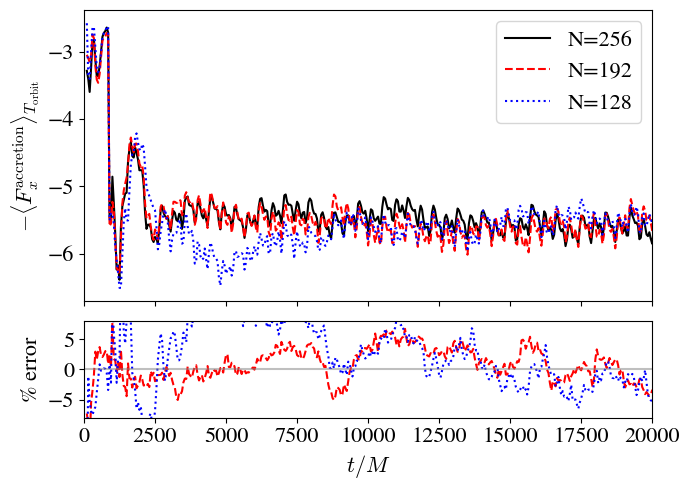

In [4]:
simnames = [ 
    # (640,'250528_BBH_r70_moreplots_restart'),
    (256, '20250620_tune_damping_n256_1'),
    (192, '20250621_tune_damping_n192'),
    (128, '20250621_tune_damping_n128')
]

plotstyles = [
    # ('-.', 'g'),
    ('-', 'k'),
    ('--', 'r'),
    (':', 'b')
]

outR=100.0
excise_factor = 1.5
average_rho_after = 7000.0



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega) 

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"


fig_fontsize = 16

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Dictionary to store data for each simulation
sim_data = {}

# First plot: drag force
for (ncell, simname), plotstyle in zip(simnames, plotstyles):
    print(simname)

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_sur = np.zeros_like(results_sur[:,4])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results_sur[:,4] + results_sur[:,7], np.ones(window_size)/window_size, mode='valid')
    smoothed_sur[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_sur[i] = np.sum(results_sur[:curr_window,4]) / curr_window

    # Calculate normalized accretion force
    
    # # normalize by mean density
    #avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    # normalized_drag = -smoothed_sur_bh1_x/avgrho
    
    # normalize by density at different times
    normalized_drag = -smoothed_sur/results_sur[:,10]
    
    # Store data for relative difference calculation
    sim_data[ncell] = {
        'time': results_sur[:,0],
        'normalized_drag': normalized_drag
    }
    
    # Plot on the first subplot
    ax1.plot(results_sur[:,0], normalized_drag, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Second plot: relative difference compared to N=256
baseline_ncell = 256
baseline_time = sim_data[baseline_ncell]['time']
baseline_drag = sim_data[baseline_ncell]['normalized_drag']

for (ncell, _), plotstyle in zip(simnames, plotstyles):
    if ncell != baseline_ncell:
        # Create interpolation function for this simulation's data
        
        current_time = sim_data[ncell]['time']
        current_drag = sim_data[ncell]['normalized_drag']
        
        # Create interpolation function with extrapolation for out-of-bounds points
        interp_func = interp1d(current_time, current_drag, bounds_error=False, fill_value="extrapolate")
        
        # Interpolate to match baseline time points
        interpolated_drag = interp_func(baseline_time)
        
        # Calculate relative difference
        rel_diff = (interpolated_drag - baseline_drag) / baseline_drag
        
        # Plot on the second subplot
        ax2.plot(baseline_time, rel_diff*100, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Configure first subplot
# ax1.set_ylim(3.5, 5.5)
ax1.set_xlim(0, 20000)
ax1.set_ylabel('$-\\langle F^{\mathrm{accretion}}_x \\rangle_{T_{\mathrm{orbit}}}$', fontsize=fig_fontsize)
ax1.legend(fontsize=fig_fontsize, loc='upper right')
# set tick fontsize
ax1.tick_params(labelsize=fig_fontsize)

# Configure second subplot
ax2.set_xlabel('$t/M$', fontsize=fig_fontsize)
ax2.set_ylabel('% error', fontsize=fig_fontsize)
ax2.set_ylim(-8, 8)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=fig_fontsize)
# ax2.legend()

# Adjust layout
plt.tight_layout()

# save as pdf
# plt.savefig('n_cell_convergence.pdf', bbox_inches='tight')


# $ \langle \tau^{\rm drag + accretion} \rangle_{T_{\rm orbit}}$ v.s. n_cell (convergence test)

20250620_tune_damping_n256_1
20250621_tune_damping_n192
20250621_tune_damping_n128


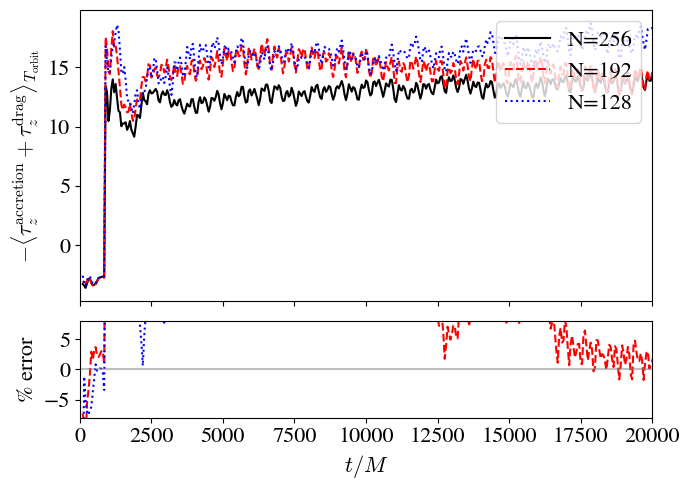

In [5]:
simnames = [ 
    # (640,'250528_BBH_r70_moreplots_restart'),
    (256, '20250620_tune_damping_n256_1'),
    (192, '20250621_tune_damping_n192'),
    (128, '20250621_tune_damping_n128')
]

plotstyles = [
    # ('-.', 'g'),
    ('-', 'k'),
    ('--', 'r'),
    (':', 'b')
]

outR=100.0
excise_factor = 1.5
average_rho_after = 7000.0

surface_factor_bbh =  1.0/np.pi
volume_factor_bbh = 0.65



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega) 

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"


fig_fontsize = 16

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Dictionary to store data for each simulation
sim_data = {}

# First plot: drag force
for (ncell, simname), plotstyle in zip(simnames, plotstyles):
    print(simname)

    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_sur = np.zeros_like(results_sur[:,0])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(  results[:,7]*volume_factor_bbh - (results_sur[:,12] + results_sur[:,13])*surface_factor_bbh, np.ones(window_size)/window_size, mode='valid')
    smoothed_sur[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_sur[i] = np.sum(results_sur[:curr_window,4]) / curr_window

    # Calculate normalized accretion force
    
    # # normalize by mean density
    #avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    # normalized_drag = -smoothed_sur_bh1_x/avgrho
    
    # normalize by density at different times
    normalized_drag = -smoothed_sur/results_sur[:,10]
    
    # Store data for relative difference calculation
    sim_data[ncell] = {
        'time': results_sur[:,0],
        'normalized_drag': normalized_drag
    }
    
    # Plot on the first subplot
    ax1.plot(results_sur[:,0], normalized_drag, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Second plot: relative difference compared to N=256
baseline_ncell = 256
baseline_time = sim_data[baseline_ncell]['time']
baseline_drag = sim_data[baseline_ncell]['normalized_drag']

for (ncell, _), plotstyle in zip(simnames, plotstyles):
    if ncell != baseline_ncell:
        # Create interpolation function for this simulation's data
        
        current_time = sim_data[ncell]['time']
        current_drag = sim_data[ncell]['normalized_drag']
        
        # Create interpolation function with extrapolation for out-of-bounds points
        interp_func = interp1d(current_time, current_drag, bounds_error=False, fill_value="extrapolate")
        
        # Interpolate to match baseline time points
        interpolated_drag = interp_func(baseline_time)
        
        # Calculate relative difference
        rel_diff = (interpolated_drag - baseline_drag) / baseline_drag
        
        # Plot on the second subplot
        ax2.plot(baseline_time, rel_diff*100, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Configure first subplot
# ax1.set_ylim(3.5, 5.5)
ax1.set_xlim(0, 20000)
ax1.set_ylabel('$-\\langle \\tau^{\mathrm{accretion}}_z +\\tau^{\mathrm{drag}}_z \\rangle_{T_{\mathrm{orbit}}}$', fontsize=fig_fontsize)
ax1.legend(fontsize=fig_fontsize, loc='upper right')
# set tick fontsize
ax1.tick_params(labelsize=fig_fontsize)

# Configure second subplot
ax2.set_xlabel('$t/M$', fontsize=fig_fontsize)
ax2.set_ylabel('% error', fontsize=fig_fontsize)
ax2.set_ylim(-8, 8)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=fig_fontsize)
# ax2.legend()

# Adjust layout
plt.tight_layout()

# save as pdf
# plt.savefig('n_cell_convergence.pdf', bbox_inches='tight')


# $ \langle F^{\rm drag} \rangle_{T_{\rm orbit}}$ v.s. velocity

20250622_tune_damping_n256_v07
20250621_tune_damping_n256_v06
20250623_tune_damping_n256_v055
20250620_tune_damping_n256_1
20250623_tune_damping_n256_v045
20250622_tune_damping_n256_v04
20250622_tune_damping_n256_v03


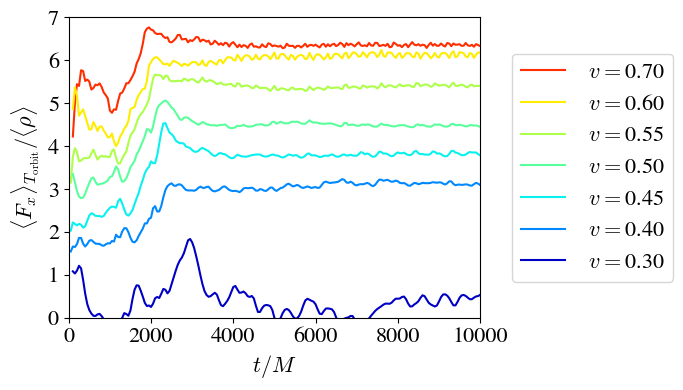

In [24]:
simnames = [ 
    (0.7, '20250622_tune_damping_n256_v07'),
    (0.6, '20250621_tune_damping_n256_v06'),
    (0.55, '20250623_tune_damping_n256_v055'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.45, '20250623_tune_damping_n256_v045'),
    (0.4, '20250622_tune_damping_n256_v04'),
    # (0.35, '20250626_n256_v035'),
    (0.3, '20250622_tune_damping_n256_v03')
]

outR=100.0
excise_factor = 1.5



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"



plt.figure().set_size_inches(7, 4)
# Create a colormap based on velocity values
velocities = [v for v, _ in simnames]
cmap = plt.cm.jet
norm = plt.Normalize(min(velocities)*0.9, max(velocities)*1.1)

for wave_vel, simname in simnames:
    print(simname)
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_drag = np.zeros_like(results[:,1])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
    smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window

    
    # Calculate normalized drag
    
    # normalize by mean density
    avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    normalized_drag = -smoothed_drag/avgrho
    
    # # normalize by density at different times
    # normalized_drag = -smoothed_drag/results_sur[:,10]

    # Get color from colormap based on velocity
    color = cmap(norm(wave_vel))
    plt.plot(results[:,0], normalized_drag, label=f' $v=${wave_vel:.2f}', color=color)


# plt.ylim(0.003,0.008)
plt.xlim(0,10000)
plt.ylim(0,7)
plt.ylabel('$\\langle F_x \\rangle_{T_{\mathrm{orbit}}} / \\langle \\rho \\rangle$', fontsize=16)
plt.xlabel('$t/M$', fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("Fdrag_vel.pdf",bbox_inches='tight')


20250627_mu02_v04_r35
20250627_mu02_v05_r35
20250627_mu02_v06_r35
20250627_mu02_v07_r35


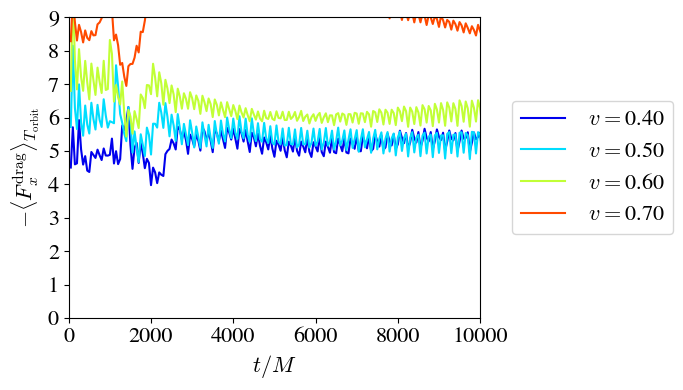

In [6]:
simnames = [ 
    # (0.7, '20250622_tune_damping_n256_v07'),
    # (0.6, '20250621_tune_damping_n256_v06'),
    # (0.55, '20250623_tune_damping_n256_v055'),
    # (0.5, '20250620_tune_damping_n256_1'),
    # (0.45, '20250623_tune_damping_n256_v045'),
    # (0.4, '20250622_tune_damping_n256_v04'),
    # # (0.35, '20250626_n256_v035'),
    # (0.3, '20250622_tune_damping_n256_v03')
    
    (0.4, '20250627_mu02_v04_r35'),
    # (0.45, '20250627_mu02_v045_r35'),
    (0.5, '20250627_mu02_v05_r35'),
    # (0.55, '20250627_mu02_v055_r35'),
    (0.6, '20250627_mu02_v06_r35'),
    (0.7, '20250627_mu02_v07_r35')
]

outR=100.0
excise_factor = 1.5



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"



plt.figure().set_size_inches(7, 4)
# Create a colormap based on velocity values
velocities = [v for v, _ in simnames]
cmap = plt.cm.jet
norm = plt.Normalize(min(velocities)*0.9, max(velocities)*1.1)

for wave_vel, simname in simnames:
    print(simname)
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_drag = np.zeros_like(results[:,1])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
    smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window

    
    # Calculate normalized drag
    
    # normalize by mean density
    # avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    # normalized_drag = -smoothed_drag/avgrho
    
    # # normalize by density at different times
    normalized_drag = -smoothed_drag/results_sur[:,10]

    # Get color from colormap based on velocity
    color = cmap(norm(wave_vel))
    plt.plot(results[:,0], normalized_drag, label=f' $v=${wave_vel:.2f}', color=color)


# plt.ylim(0.003,0.008)
plt.xlim(0,10000)
plt.ylim(0,9)
plt.ylabel('$-\\langle F^{\mathrm{drag}}_x \\rangle_{T_{\mathrm{orbit}}}$', fontsize=16)
plt.xlabel('$t/M$', fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("Fdrag_vel_r35.pdf",bbox_inches='tight')


20250630_ncell416_v02_mu005_r35
20250630_ncell416_v03_mu005_r35
20250630_ncell416_v04_mu005_r35
20250630_ncell416_v05_mu005_r35


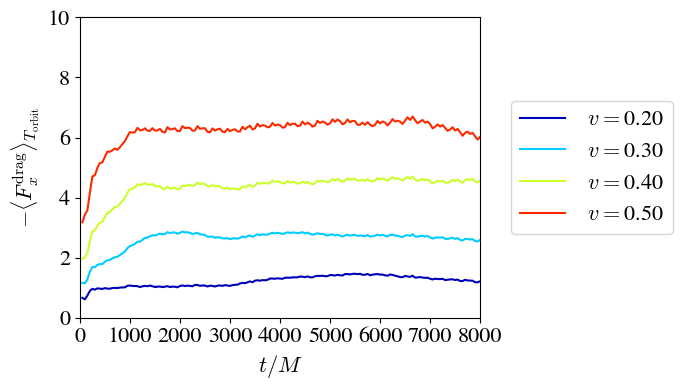

In [35]:
simnames = [ 
    # (0.7, '20250622_tune_damping_n256_v07'),
    # (0.6, '20250621_tune_damping_n256_v06'),
    # (0.55, '20250623_tune_damping_n256_v055'),
    # (0.5, '20250620_tune_damping_n256_1'),
    # (0.45, '20250623_tune_damping_n256_v045'),
    # (0.4, '20250622_tune_damping_n256_v04'),
    # # (0.35, '20250626_n256_v035'),
    # (0.3, '20250622_tune_damping_n256_v03')
    
    # (0.4, '20250627_mu02_v04_r35'),
    # (0.45, '20250627_mu02_v045_r35'),
    # (0.5, '20250627_mu02_v05_r35'),
    # (0.55, '20250627_mu02_v055_r35'),
    # (0.6, '20250627_mu02_v06_r35'),
    # (0.7, '20250627_mu02_v07_r35')
    (0.2, '20250630_ncell416_v02_mu005_r35'),
    (0.3, '20250630_ncell416_v03_mu005_r35'),
    (0.4, '20250630_ncell416_v04_mu005_r35'),
    (0.5, '20250630_ncell416_v05_mu005_r35'),
    # (0.6, '20250630_ncell416_v06_mu005'),
    # (0.7, '20250630_ncell416_v07_mu005'),
    
]

outR=100.0
excise_factor = 1.5



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"



plt.figure().set_size_inches(7, 4)
# Create a colormap based on velocity values
velocities = [v for v, _ in simnames]
cmap = plt.cm.jet
norm = plt.Normalize(min(velocities)*0.9, max(velocities)*1.1)

for wave_vel, simname in simnames:
    print(simname)
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_drag = np.zeros_like(results[:,1])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
    smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window

    
    # Calculate normalized drag
    
    # normalize by mean density
    avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    normalized_drag = -smoothed_drag/avgrho
    
    # # # normalize by density at different times
    # normalized_drag = -smoothed_drag/results_sur[:,10]

    # Get color from colormap based on velocity
    color = cmap(norm(wave_vel))
    plt.plot(results[:,0], normalized_drag, label=f' $v=${wave_vel:.2f}', color=color)


# plt.ylim(0.003,0.008)
plt.xlim(0,8000)
plt.ylim(0,10)
plt.ylabel('$-\\langle F^{\mathrm{drag}}_x \\rangle_{T_{\mathrm{orbit}}}$', fontsize=16)
plt.xlabel('$t/M$', fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("Fdrag_vel_mu005.pdf",bbox_inches='tight')


# $ \langle \tau_z^{\rm drag}+\tau_z^{\rm accretion} \rangle_{T_{\rm orbit}}$ v.s. velocity

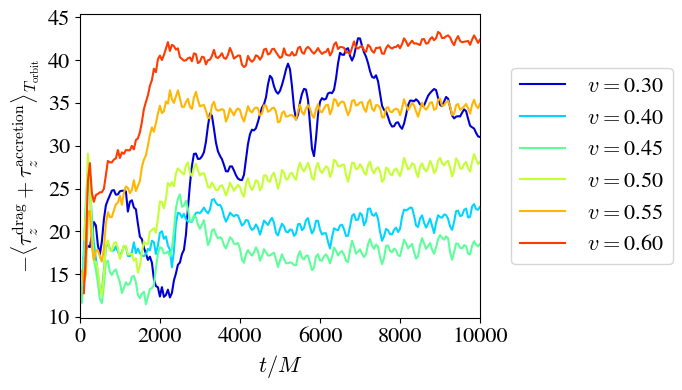

In [4]:
simnames = [ 
    (0.3, '20250622_tune_damping_n256_v03'),
    # (0.35, '20250626_n256_v035'),
    (0.4, '20250622_tune_damping_n256_v04'),
    (0.45, '20250623_tune_damping_n256_v045'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.55, '20250623_tune_damping_n256_v055'),
    (0.6, '20250621_tune_damping_n256_v06')
    # ,    (0.7, '20250622_tune_damping_n256_v07')
]

outR=320.0
excise_factor = 1.5

average_rho_after = 5000

surface_factor_bbh =  1.0/np.pi
volume_factor_bbh = 1.2




binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"


plt.figure().set_size_inches(7, 4)
# Create a colormap based on velocity values
velocities = [v for v, _ in simnames]
cmap = plt.cm.jet
norm = plt.Normalize(min(velocities)*0.9, max(velocities)*1.1)
for wave_vel, simname in simnames:
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    valid_smoothed_torque = np.convolve(results[:,7]*volume_factor_bbh - (results_sur[:,12] + results_sur[:,13])*surface_factor_bbh, np.ones(window_size)/window_size, mode='valid')
    smoothed_torque = np.zeros_like(results[:,0])
    smoothed_torque[window_size-1:window_size-1+len(valid_smoothed_torque)] = valid_smoothed_torque
    # handle the left boundary
    for i in range(window_size-1):
        curr_window = i + 1
        smoothed_torque[i] = np.sum(results[:curr_window,7]*volume_factor_bbh - (results_sur[:curr_window,12] + results_sur[:curr_window,13])*surface_factor_bbh) / curr_window


    # Calculate normalized drag
    
    # normalize by mean density
    avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    normalized_torque = -smoothed_torque/avgrho
    
    # # normalize by density at different times
    # normalized_torque = -smoothed_torque/results_sur[:,10]

    color = cmap(norm(wave_vel))
    plt.plot(results[:,0], normalized_torque, label=f' $v=${wave_vel:.2f}', color=color)

# plt.ylim(0.003,0.008)
plt.xlim(0,10000)
plt.ylabel('$-\\langle \\tau_z^{\mathrm{drag}} + \\tau_z^{\mathrm{accretion}} \\rangle_{T_{\mathrm{orbit}}}$', fontsize=16)
plt.xlabel('$t/M$', fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig('torque_vel.pdf', bbox_inches='tight')

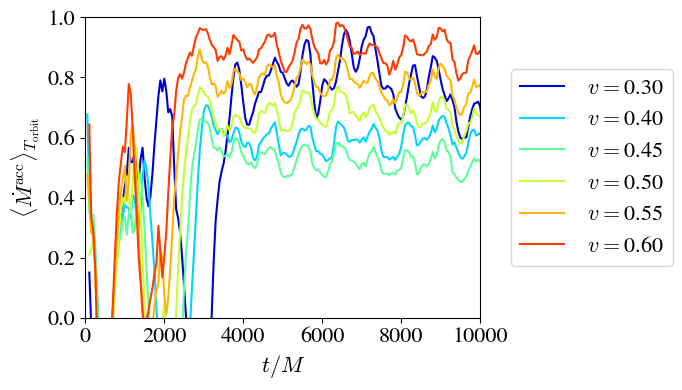

In [42]:
simnames = [ 
    (0.3, '20250622_tune_damping_n256_v03'),
    # (0.35, '20250626_n256_v035'),
    (0.4, '20250622_tune_damping_n256_v04'),
    (0.45, '20250623_tune_damping_n256_v045'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.55, '20250623_tune_damping_n256_v055'),
    (0.6, '20250621_tune_damping_n256_v06')
    # ,    (0.7, '20250622_tune_damping_n256_v07')
]

outR=320.0
excise_factor = 1.5

surface_factor_bbh = 1.0/np.pi
volume_factor_bbh = 0.5

binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"

plt.figure().set_size_inches(7, 4)
# Create a colormap based on velocity values
velocities = [v for v, _ in simnames]
cmap = plt.cm.jet
norm = plt.Normalize(min(velocities)*0.9, max(velocities)*1.1)

for wave_vel, simname in simnames:
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    valid_smoothed_torque = np.convolve(results[:,10]*volume_factor_bbh - (results_sur[:,16] + results_sur[:,17])*surface_factor_bbh, np.ones(window_size)/window_size, mode='valid')
    smoothed_torque = np.zeros_like(results[:,0])
    smoothed_torque[window_size-1:window_size-1+len(valid_smoothed_torque)] = valid_smoothed_torque
    # handle the left boundary
    for i in range(window_size-1):
        curr_window = i + 1
        smoothed_torque[i] = np.sum(results[:curr_window,10]*volume_factor_bbh - (results_sur[:curr_window,16] + results_sur[:curr_window,17])*surface_factor_bbh) / curr_window

    # Calculate normalized drag
    
    # normalize by mean density
    avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    normalized_torque = -smoothed_torque/avgrho
    
    # # normalize by density at different times
    # normalized_torque = -smoothed_torque/results_sur[:,10]

    color = cmap(norm(wave_vel))
    plt.plot(results[:,0], normalized_torque, label=f' $v=${wave_vel:.2f}', color=color)

# plt.ylim(0.003,0.008)
plt.ylim(0,1)
plt.xlim(0,10000)
plt.ylabel('$\\langle \\dot{M}^{\\mathrm{acc}} \\rangle_{T_{\\mathrm{orbit}}}$', fontsize=16)
plt.xlabel('$t/M$', fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("Macc_vel.pdf", bbox_inches='tight')


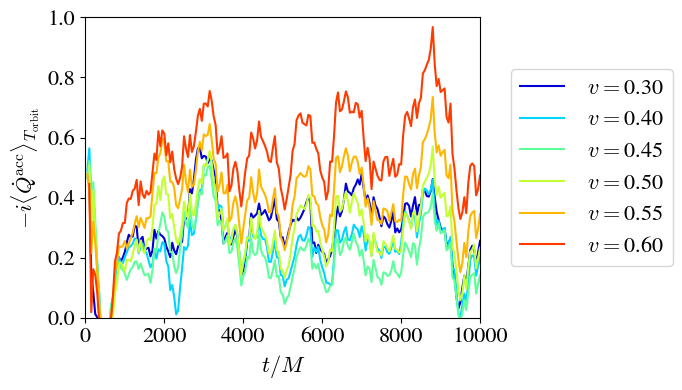

In [43]:
simnames = [ 
    (0.3, '20250622_tune_damping_n256_v03'),
    # (0.35, '20250626_n256_v035'),
    (0.4, '20250622_tune_damping_n256_v04'),
    (0.45, '20250623_tune_damping_n256_v045'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.55, '20250623_tune_damping_n256_v055'),
    (0.6, '20250621_tune_damping_n256_v06')
    # ,    (0.7, '20250622_tune_damping_n256_v07')
]

outR=320.0
excise_factor = 1.5

binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"

plt.figure().set_size_inches(7, 4)
# Create a colormap based on velocity values
velocities = [v for v, _ in simnames]
cmap = plt.cm.jet
norm = plt.Normalize(min(velocities)*0.9, max(velocities)*1.1)

for wave_vel, simname in simnames:
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    q_charge_flux = np.convolve((results_sur[:,18] + results_sur[:,19]), np.ones(window_size)/window_size, mode='valid')
    smoothed_q_charge_flux = np.zeros_like(results[:,0])
    smoothed_q_charge_flux[window_size-1:window_size-1+len(q_charge_flux)] = q_charge_flux
    # handle the left boundary
    for i in range(window_size-1):
        curr_window = i + 1
        smoothed_q_charge_flux[i] = np.sum(results_sur[:curr_window,18] + results_sur[:curr_window,19]) / curr_window

    # Calculate normalized drag
    
    # normalize by mean density
    avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
    normalized_q_charge_flux = -smoothed_q_charge_flux/avgrho
    
    # # normalize by density at different times
    # normalized_q_charge_flux = -smoothed_q_charge_flux/results_sur[:,10]

    color = cmap(norm(wave_vel))
    plt.plot(results[:,0], normalized_q_charge_flux, label=f' $v=${wave_vel:.2f}', color=color)

# plt.ylim(0.003,0.008)
plt.ylim(0,1)
plt.xlim(0,10000)
plt.ylabel('$-i\\langle \\dot{Q}^{\\mathrm{acc}} \\rangle_{T_{\\mathrm{orbit}}}$', fontsize=16)
plt.xlabel('$t/M$', fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("Qacc_vel.pdf", bbox_inches='tight')


T_orbit =  869.7963420350058
Processing velocity 0.3
Processing velocity 0.4
Processing velocity 0.45
Processing velocity 0.5
Processing velocity 0.55
Processing velocity 0.6
Processing velocity 0.7

Computed Statistics (average ± std):
Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion
---------------------------------------------------------------------------
0.30 | -0.0254 ± 0.1965 | 35.2190 ± 3.3373 | 0.7780 ± 0.0881 | 0.3110 ± 0.0900
0.40 | 3.0080 ± 0.0731 | 21.1215 ± 1.1017 | 0.5880 ± 0.0387 | 0.2356 ± 0.0808
0.45 | 3.6382 ± 0.0363 | 17.6752 ± 0.8309 | 0.5078 ± 0.0400 | 0.1758 ± 0.0755
0.50 | 4.6506 ± 0.0300 | 27.4344 ± 0.8129 | 0.6319 ± 0.0514 | 0.3317 ± 0.1202
0.55 | 5.4590 ± 0.0386 | 34.5607 ± 0.6635 | 0.7594 ± 0.0504 | 0.3889 ± 0.1057
0.60 | 6.1235 ± 0.0548 | 41.7719 ± 0.8792 | 0.8782 ± 0.0489 | 0.5567 ± 0.1365
0.70 | 6.4136 ± 0.0346 | 27.3808 ± 0.8762 | 0.7432 ± 0.0589 | 0.5247 ± 0.1682


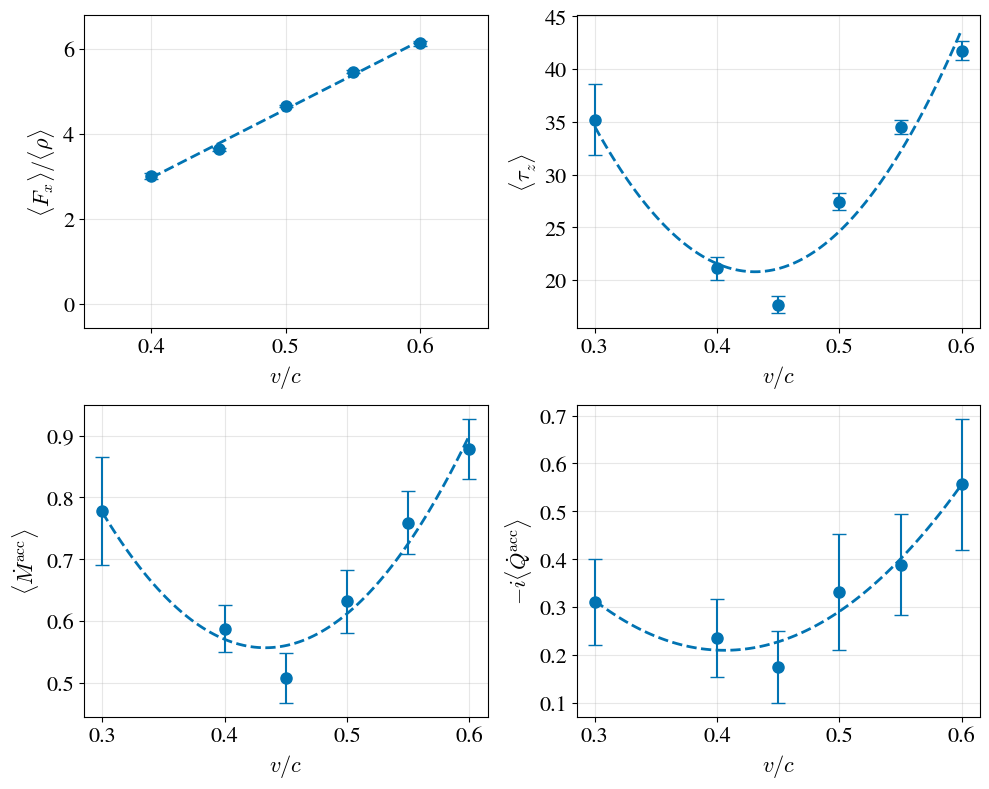

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define the threshold time for computing averages
t_threshold = 4000

# Arrays to store velocity and computed values
velocities = []
fdrag_avg = []
fdrag_std = []
torque_avg = []
torque_std = []
macc_avg = []
macc_std = []
qacc_avg = []
qacc_std = []

# Use all available velocities from previous cells
simnames = [ 
    (0.3, '20250622_tune_damping_n256_v03'),
    # (0.35, '20250626_n256_v035'),
    (0.4, '20250622_tune_damping_n256_v04'),
    (0.45, '20250623_tune_damping_n256_v045'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.55, '20250623_tune_damping_n256_v055'),
    (0.6, '20250621_tune_damping_n256_v06'),
    (0.7, '20250622_tune_damping_n256_v07')
]

# Parameters needed for calculations
outR = 320.0  # Using the larger outR value
excise_factor = 1.5
average_rho_after = 5000
surface_factor_bbh = 1.0/np.pi
volume_factor_bbh_torque = 1.2  # For torque calculation
volume_factor_bbh_macc = 0.5    # For mass accretion calculation


binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
binary_omega = - 0.002657634562418009 * 2.71811
T_orbit = np.abs(2*np.pi/binary_omega) 

print("T_orbit = ", T_orbit)

# Process each velocity
for wave_vel, simname in simnames:
    print(f"Processing velocity {wave_vel}")
    
    try:
        # Load the data
        results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")
        results = results[1:]  # Remove first data point
        
        results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
        results_sur = results_sur[1:]
        
        dt = results[1,0] - results[0,0]
        window_size = int(T_orbit/dt)
        
        # Average density for normalization
        avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
        
        # 1. Drag Force calculation
        smoothed_drag = np.zeros_like(results[:,1])
        valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
        smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window
        
        normalized_drag = -smoothed_drag/avgrho
        
        # 2. Torque calculation
        smoothed_torque = np.zeros_like(results[:,0])
        valid_smoothed_torque = np.convolve(
            results[:,7]*volume_factor_bbh_torque - (results_sur[:,12] + results_sur[:,13])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_torque[window_size-1:window_size-1+len(valid_smoothed_torque)] = valid_smoothed_torque
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_torque[i] = np.sum(
                results[:curr_window,7]*volume_factor_bbh_torque - 
                (results_sur[:curr_window,12] + results_sur[:curr_window,13])*surface_factor_bbh
            ) / curr_window
        
        normalized_torque = -smoothed_torque/avgrho
        
        # 3. Mass Accretion calculation
        smoothed_macc = np.zeros_like(results[:,0])
        valid_smoothed_macc = np.convolve(
            results[:,10]*volume_factor_bbh_macc - (results_sur[:,16] + results_sur[:,17])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_macc[window_size-1:window_size-1+len(valid_smoothed_macc)] = valid_smoothed_macc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_macc[i] = np.sum(
                results[:curr_window,10]*volume_factor_bbh_macc - 
                (results_sur[:curr_window,16] + results_sur[:curr_window,17])*surface_factor_bbh
            ) / curr_window
        
        normalized_macc = -smoothed_macc/avgrho
        
        # 4. Charge Accretion calculation
        smoothed_qacc = np.zeros_like(results[:,0])
        valid_smoothed_qacc = np.convolve(
            (results_sur[:,18] + results_sur[:,19]), 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_qacc[window_size-1:window_size-1+len(valid_smoothed_qacc)] = valid_smoothed_qacc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_qacc[i] = np.sum(results_sur[:curr_window,18] + results_sur[:curr_window,19]) / curr_window
        
        normalized_qacc = -smoothed_qacc/avgrho
        
        # Calculate statistics for t > t_threshold
        mask = results[:,0] > t_threshold
        
        # Store velocity and computed statistics
        velocities.append(wave_vel)
        
        # Drag force
        fdrag_avg.append(np.mean(normalized_drag[mask]))
        fdrag_std.append(np.std(normalized_drag[mask]))
        
        # Torque
        torque_avg.append(np.mean(normalized_torque[mask]))
        torque_std.append(np.std(normalized_torque[mask]))
        
        # Mass accretion
        macc_avg.append(np.mean(normalized_macc[mask]))
        macc_std.append(np.std(normalized_macc[mask]))
        
        # Charge accretion
        qacc_avg.append(np.mean(normalized_qacc[mask]))
        qacc_std.append(np.std(normalized_qacc[mask]))
        
    except Exception as e:
        print(f"Error processing velocity {wave_vel}: {e}")

# Convert to numpy arrays for easier processing
velocities = np.array(velocities)
fdrag_avg = np.array(fdrag_avg)
fdrag_std = np.array(fdrag_std)
torque_avg = np.array(torque_avg)
torque_std = np.array(torque_std)
macc_avg = np.array(macc_avg)
macc_std = np.array(macc_std)
qacc_avg = np.array(qacc_avg)
qacc_std = np.array(qacc_std)

# Sort everything by velocity
sort_indices = np.argsort(velocities)
velocities = velocities[sort_indices]
fdrag_avg = fdrag_avg[sort_indices]
fdrag_std = fdrag_std[sort_indices]
torque_avg = torque_avg[sort_indices]
torque_std = torque_std[sort_indices]
macc_avg = macc_avg[sort_indices]
macc_std = macc_std[sort_indices]
qacc_avg = qacc_avg[sort_indices]
qacc_std = qacc_std[sort_indices]

# Create 2x2 panel plot - smaller size to make text relatively bigger
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, figure=fig)

# Use color_tune_damping for this plot set
color = color_tune_damping

# 1. Drag Force vs Velocity
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(velocities, fdrag_avg, yerr=fdrag_std, fmt='o', capsize=5, markersize=8, color=color)

# Add linear fit for drag force using only data between v=0.4 and v=0.6
fdrag_mask = (velocities >= 0.4) & (velocities <= 0.6)
fdrag_fit = np.polyfit(velocities[fdrag_mask], fdrag_avg[fdrag_mask], 1)
x_fit_fdrag = np.linspace(0.4, 0.6, 100)
fdrag_line = np.polyval(fdrag_fit, x_fit_fdrag)
ax1.plot(x_fit_fdrag, fdrag_line, '--', linewidth=2, color=color)

ax1.set_xlim(0.35, 0.65)
ax1.set_xlabel('$v/c$', fontsize=16)
ax1.set_ylabel('$\\langle F_x \\rangle/\\langle \\rho \\rangle$', fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=16)

# For the remaining plots, filter out v=0.7 data
velocity_mask = velocities < 0.7
velocities_filtered = velocities[velocity_mask]
torque_avg_filtered = torque_avg[velocity_mask]
torque_std_filtered = torque_std[velocity_mask]
macc_avg_filtered = macc_avg[velocity_mask]
macc_std_filtered = macc_std[velocity_mask]
qacc_avg_filtered = qacc_avg[velocity_mask]
qacc_std_filtered = qacc_std[velocity_mask]

# 2. Torque vs Velocity
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(velocities_filtered, torque_avg_filtered, yerr=torque_std_filtered, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for torque
torque_fit = np.polyfit(velocities_filtered, torque_avg_filtered, 2)
x_fit = np.linspace(min(velocities_filtered), max(velocities_filtered), 100)
torque_curve = np.polyval(torque_fit, x_fit)
ax2.plot(x_fit, torque_curve, '--', linewidth=2, color=color)

ax2.set_xlabel('$v/c$', fontsize=16)
ax2.set_ylabel('$\\langle \\tau_z^ \\rangle$', fontsize=16)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=16)

# 3. Mass Accretion vs Velocity
ax3 = fig.add_subplot(gs[1, 0])
ax3.errorbar(velocities_filtered, macc_avg_filtered, yerr=macc_std_filtered, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for mass accretion
macc_fit = np.polyfit(velocities_filtered, macc_avg_filtered, 2)
macc_curve = np.polyval(macc_fit, x_fit)
ax3.plot(x_fit, macc_curve, '--', linewidth=2, color=color)

ax3.set_xlabel('$v/c$', fontsize=16)
ax3.set_ylabel('$\\langle \\dot{M}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=16)

# 4. Charge Accretion vs Velocity
ax4 = fig.add_subplot(gs[1, 1])
ax4.errorbar(velocities_filtered, qacc_avg_filtered, yerr=qacc_std_filtered, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for charge accretion
qacc_fit = np.polyfit(velocities_filtered, qacc_avg_filtered, 2)
qacc_curve = np.polyval(qacc_fit, x_fit)
ax4.plot(x_fit, qacc_curve, '--', linewidth=2, color=color)

ax4.set_xlabel('$v/c$', fontsize=16)
ax4.set_ylabel('$-i\\langle \\dot{Q}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig("quantities_vs_velocity.pdf", bbox_inches='tight')

# Print the computed values for reference
print("\nComputed Statistics (average ± std):")
print("Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion")
print("-" * 75)
for i, v in enumerate(velocities):
    print(f"{v:.2f} | {fdrag_avg[i]:.4f} ± {fdrag_std[i]:.4f} | {torque_avg[i]:.4f} ± {torque_std[i]:.4f} | {macc_avg[i]:.4f} ± {macc_std[i]:.4f} | {qacc_avg[i]:.4f} ± {qacc_std[i]:.4f}")


Processing velocity 0.3
Processing velocity 0.4
Processing velocity 0.45
Processing velocity 0.5
Processing velocity 0.55
Processing velocity 0.6
Processing velocity 0.7

Computed Statistics (average ± std):
Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion
---------------------------------------------------------------------------
0.30 | 3.0328 ± 0.6859 | 8.0102 ± 1.7484 | 1.3335 ± 0.3924 | 0.4045 ± 1.4026
0.40 | 5.5110 ± 0.2230 | 14.6463 ± 1.9918 | 1.8346 ± 0.4903 | 1.0420 ± 0.9028
0.45 | 4.3252 ± 0.2321 | 17.9139 ± 1.7466 | 1.8940 ± 0.4001 | 1.2651 ± 0.9650
0.50 | 5.3868 ± 0.2237 | 23.7718 ± 2.0263 | 2.2811 ± 0.4405 | 1.3621 ± 1.1757
0.55 | 5.7694 ± 0.4931 | 30.5114 ± 4.1927 | 2.7673 ± 0.4715 | 1.7091 ± 1.8467
0.60 | 6.1781 ± 0.1399 | 23.9334 ± 2.7713 | 2.6458 ± 0.4585 | 1.4768 ± 2.5754
0.70 | 9.2183 ± 0.3379 | 14.5469 ± 6.1900 | 2.2864 ± 0.4799 | 1.1084 ± 4.2595


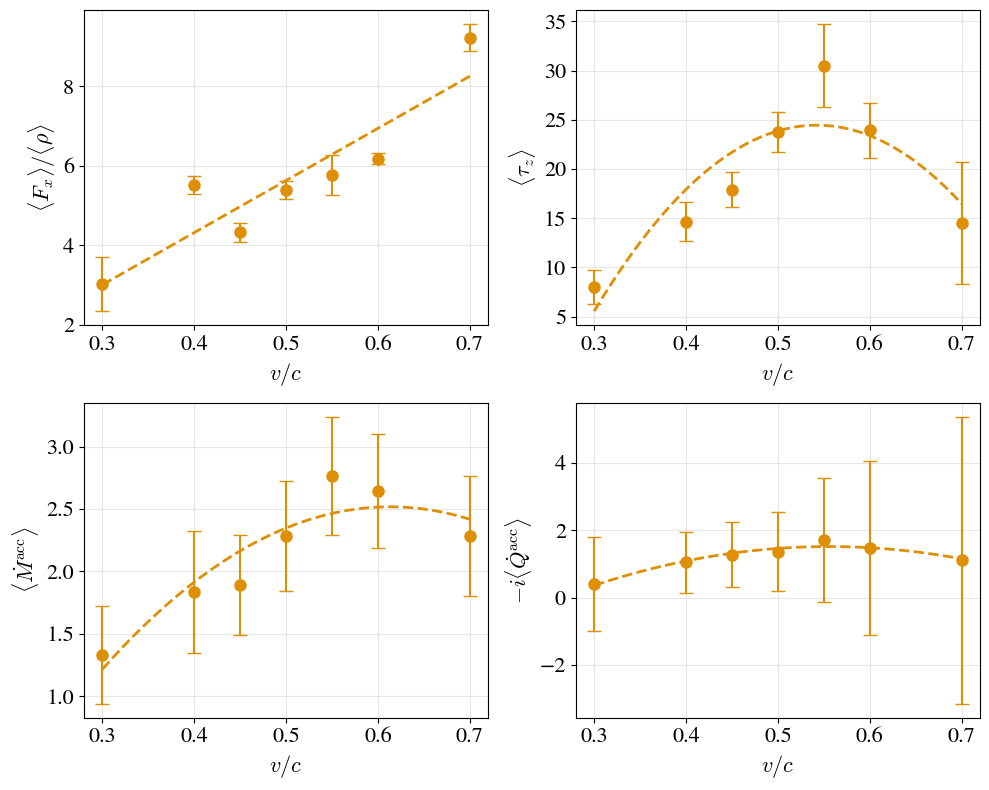

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define the threshold time for computing averages
t_threshold = 4000

# Arrays to store velocity and computed values
velocities = []
fdrag_avg = []
fdrag_std = []
torque_avg = []
torque_std = []
macc_avg = []
macc_std = []
qacc_avg = []
qacc_std = []

# Use all available velocities from previous cells
simnames = [     
    (0.3, '20250702_mu02_v03_r35'),
    (0.4, '20250627_mu02_v04_r35'),
    (0.45, '20250628_mu02_v045_r35'),
    (0.5, '20250627_mu02_v05_r35'),
    (0.55, '20250628_mu02_v055_r35'),
    (0.6, '20250627_mu02_v06_r35'),
    (0.7, '20250627_mu02_v07_r35')
]

# Parameters needed for calculations
outR = 320.0  # Using the larger outR value
excise_factor = 1.5
average_rho_after = 5000
surface_factor_bbh = 1.0/np.pi
volume_factor_bbh_torque = 1.2  # For torque calculation
volume_factor_bbh_macc = 0.5    # For mass accretion calculation




# Process each velocity
for wave_vel, simname in simnames:
    print(f"Processing velocity {wave_vel}")
    
    try:
        # Load the data
        results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")
        results = results[1:]  # Remove first data point
        
        results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
        results_sur = results_sur[1:]
        
        dt = results[1,0] - results[0,0]
        window_size = int(T_orbit/dt)
        
        # Average density for normalization
        avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
        
        # 1. Drag Force calculation
        smoothed_drag = np.zeros_like(results[:,1])
        valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
        smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window
        
        normalized_drag = -smoothed_drag/avgrho
        
        # 2. Torque calculation
        smoothed_torque = np.zeros_like(results[:,0])
        valid_smoothed_torque = np.convolve(
            results[:,7]*volume_factor_bbh_torque - (results_sur[:,12] + results_sur[:,13])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_torque[window_size-1:window_size-1+len(valid_smoothed_torque)] = valid_smoothed_torque
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_torque[i] = np.sum(
                results[:curr_window,7]*volume_factor_bbh_torque - 
                (results_sur[:curr_window,12] + results_sur[:curr_window,13])*surface_factor_bbh
            ) / curr_window
        
        normalized_torque = -smoothed_torque/avgrho
        
        # 3. Mass Accretion calculation
        smoothed_macc = np.zeros_like(results[:,0])
        valid_smoothed_macc = np.convolve(
            results[:,10]*volume_factor_bbh_macc - (results_sur[:,16] + results_sur[:,17])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_macc[window_size-1:window_size-1+len(valid_smoothed_macc)] = valid_smoothed_macc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_macc[i] = np.sum(
                results[:curr_window,10]*volume_factor_bbh_macc - 
                (results_sur[:curr_window,16] + results_sur[:curr_window,17])*surface_factor_bbh
            ) / curr_window
        
        normalized_macc = -smoothed_macc/avgrho
        
        # 4. Charge Accretion calculation
        smoothed_qacc = np.zeros_like(results[:,0])
        valid_smoothed_qacc = np.convolve(
            (results_sur[:,18] + results_sur[:,19]), 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_qacc[window_size-1:window_size-1+len(valid_smoothed_qacc)] = valid_smoothed_qacc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_qacc[i] = np.sum(results_sur[:curr_window,18] + results_sur[:curr_window,19]) / curr_window
        
        normalized_qacc = -smoothed_qacc/avgrho
        
        # Calculate statistics for t > t_threshold
        mask = results[:,0] > t_threshold
        
        # Store velocity and computed statistics
        velocities.append(wave_vel)
        
        # Drag force
        fdrag_avg.append(np.mean(normalized_drag[mask]))
        fdrag_std.append(np.std(normalized_drag[mask]))
        
        # Torque
        torque_avg.append(np.mean(normalized_torque[mask]))
        torque_std.append(np.std(normalized_torque[mask]))
        
        # Mass accretion
        macc_avg.append(np.mean(normalized_macc[mask]))
        macc_std.append(np.std(normalized_macc[mask]))
        
        # Charge accretion
        qacc_avg.append(np.mean(normalized_qacc[mask]))
        qacc_std.append(np.std(normalized_qacc[mask]))
        
    except Exception as e:
        print(f"Error processing velocity {wave_vel}: {e}")

# Convert to numpy arrays for easier processing
velocities = np.array(velocities)
fdrag_avg = np.array(fdrag_avg)
fdrag_std = np.array(fdrag_std)
torque_avg = np.array(torque_avg)
torque_std = np.array(torque_std)
macc_avg = np.array(macc_avg)
macc_std = np.array(macc_std)
qacc_avg = np.array(qacc_avg)
qacc_std = np.array(qacc_std)

# Sort everything by velocity
sort_indices = np.argsort(velocities)
velocities = velocities[sort_indices]
fdrag_avg = fdrag_avg[sort_indices]
fdrag_std = fdrag_std[sort_indices]
torque_avg = torque_avg[sort_indices]
torque_std = torque_std[sort_indices]
macc_avg = macc_avg[sort_indices]
macc_std = macc_std[sort_indices]
qacc_avg = qacc_avg[sort_indices]
qacc_std = qacc_std[sort_indices]

# Create 2x2 panel plot - smaller size to make text relatively bigger
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, figure=fig)

color = color_mu02

# 1. Drag Force vs Velocity
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(velocities, fdrag_avg, yerr=fdrag_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for drag force using all data points
fdrag_fit = np.polyfit(velocities, fdrag_avg, 1)
x_fit_fdrag = np.linspace(min(velocities), max(velocities), 100)
fdrag_curve = np.polyval(fdrag_fit, x_fit_fdrag)
ax1.plot(x_fit_fdrag, fdrag_curve, '--', linewidth=2, color=color)

ax1.set_xlabel('$v/c$', fontsize=16)
ax1.set_ylabel('$\\langle F_x \\rangle/\\langle \\rho \\rangle$', fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=16)

# 2. Torque vs Velocity
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(velocities, torque_avg, yerr=torque_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for torque
torque_fit = np.polyfit(velocities, torque_avg, 2)
x_fit = np.linspace(min(velocities), max(velocities), 100)
torque_curve = np.polyval(torque_fit, x_fit)
ax2.plot(x_fit, torque_curve, '--', linewidth=2, color=color)

ax2.set_xlabel('$v/c$', fontsize=16)
ax2.set_ylabel('$\\langle \\tau_z \\rangle$', fontsize=16)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=16)

# 3. Mass Accretion vs Velocity
ax3 = fig.add_subplot(gs[1, 0])
ax3.errorbar(velocities, macc_avg, yerr=macc_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for mass accretion
macc_fit = np.polyfit(velocities, macc_avg, 2)
macc_curve = np.polyval(macc_fit, x_fit)
ax3.plot(x_fit, macc_curve, '--', linewidth=2, color=color)

ax3.set_xlabel('$v/c$', fontsize=16)
ax3.set_ylabel('$\\langle \\dot{M}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=16)

# 4. Charge Accretion vs Velocity
ax4 = fig.add_subplot(gs[1, 1])
ax4.errorbar(velocities, qacc_avg, yerr=qacc_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for charge accretion
qacc_fit = np.polyfit(velocities, qacc_avg, 2)
qacc_curve = np.polyval(qacc_fit, x_fit)
ax4.plot(x_fit, qacc_curve, '--', linewidth=2, color=color)

ax4.set_xlabel('$v/c$', fontsize=16)
ax4.set_ylabel('$-i\\langle \\dot{Q}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig("quantities_vs_velocity_r35.pdf", bbox_inches='tight')

# Print the computed values for reference
print("\nComputed Statistics (average ± std):")
print("Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion")
print("-" * 75)
for i, v in enumerate(velocities):
    print(f"{v:.2f} | {fdrag_avg[i]:.4f} ± {fdrag_std[i]:.4f} | {torque_avg[i]:.4f} ± {torque_std[i]:.4f} | {macc_avg[i]:.4f} ± {macc_std[i]:.4f} | {qacc_avg[i]:.4f} ± {qacc_std[i]:.4f}")


Processing velocity 0.4
Processing velocity 0.45
Processing velocity 0.5
Processing velocity 0.55
Processing velocity 0.6

Computed Statistics (average ± std):
Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion
---------------------------------------------------------------------------
0.40 | 0.5339 ± 0.1709 | 30.1324 ± 2.3405 | 1.2295 ± 0.1060 | 0.6371 ± 0.2225
0.45 | 0.7526 ± 0.1600 | 26.6382 ± 4.0150 | 1.1290 ± 0.1149 | 0.2345 ± 0.2445
0.50 | 0.9894 ± 0.2316 | 24.0978 ± 2.8993 | 1.0765 ± 0.1444 | 0.3156 ± 0.3442
0.55 | 0.9075 ± 0.2446 | 23.0487 ± 5.5541 | 1.1181 ± 0.1515 | 0.1751 ± 0.3892
0.60 | 1.0039 ± 0.2485 | 24.5583 ± 3.5153 | 1.0980 ± 0.2380 | 0.1735 ± 0.7857


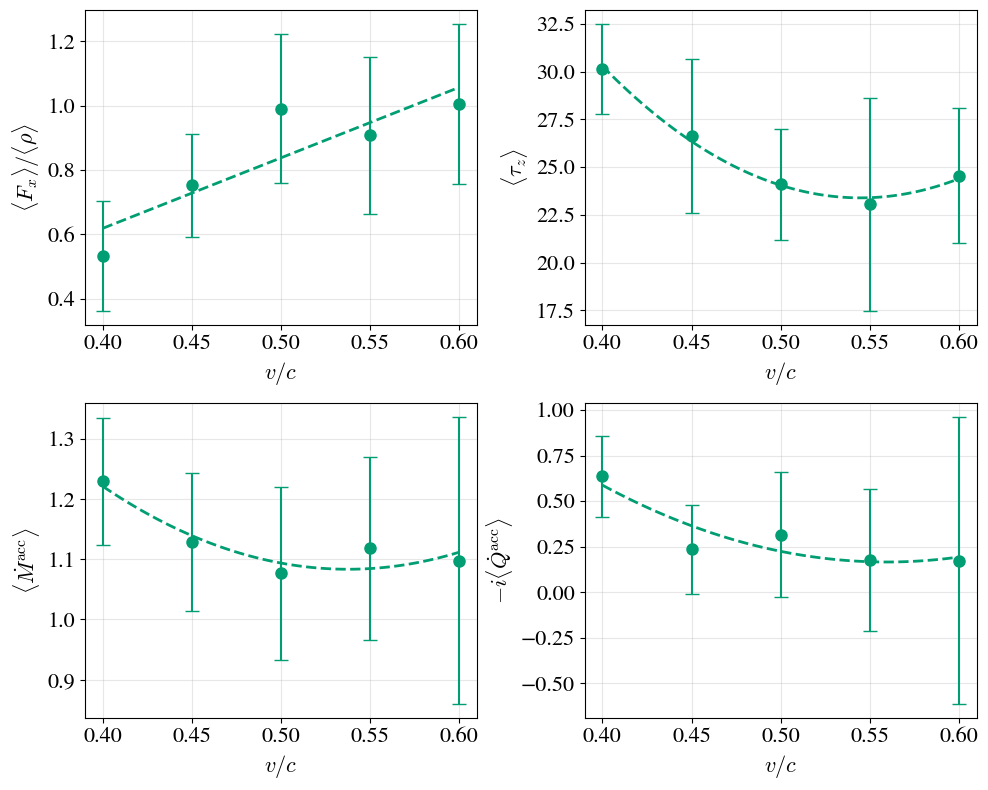

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define the threshold time for computing averages
t_threshold = 4000

# Arrays to store velocity and computed values
velocities = []
fdrag_avg = []
fdrag_std = []
torque_avg = []
torque_std = []
macc_avg = []
macc_std = []
qacc_avg = []
qacc_std = []

# Use all available velocities from previous cells
simnames = [     
    (0.4, '20250628_ncell320_v04_mu08'),
    (0.45, '20250629_ncell320_v045_mu08'),
    (0.5, '20250629_ncell320_v05_mu08'),
    (0.55, '20250629_ncell320_v055_mu08'),
    (0.6, '20250628_ncell320_v06_mu08')
    # , (0.7, '20250628_ncell320_v07_mu08')
]

# Parameters needed for calculations
outR = 100.0  # Using the larger outR value
excise_factor = 1.5
average_rho_after = 5000
surface_factor_bbh = 1.0/np.pi
volume_factor_bbh_torque = 1.2  # For torque calculation
volume_factor_bbh_macc = 0.5    # For mass accretion calculation

# Process each velocity
for wave_vel, simname in simnames:
    print(f"Processing velocity {wave_vel}")
    
    try:
        # Load the data
        results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")
        results = results[1:]  # Remove first data point
        
        results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
        results_sur = results_sur[1:]
        
        dt = results[1,0] - results[0,0]
        window_size = int(T_orbit/dt)
        
        # Average density for normalization
        avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
        
        # 1. Drag Force calculation
        smoothed_drag = np.zeros_like(results[:,1])
        valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
        smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window
        
        normalized_drag = -smoothed_drag/avgrho
        
        # 2. Torque calculation
        smoothed_torque = np.zeros_like(results[:,0])
        valid_smoothed_torque = np.convolve(
            results[:,7]*volume_factor_bbh_torque - (results_sur[:,12] + results_sur[:,13])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_torque[window_size-1:window_size-1+len(valid_smoothed_torque)] = valid_smoothed_torque
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_torque[i] = np.sum(
                results[:curr_window,7]*volume_factor_bbh_torque - 
                (results_sur[:curr_window,12] + results_sur[:curr_window,13])*surface_factor_bbh
            ) / curr_window
        
        normalized_torque = -smoothed_torque/avgrho
        
        # 3. Mass Accretion calculation
        smoothed_macc = np.zeros_like(results[:,0])
        valid_smoothed_macc = np.convolve(
            results[:,10]*volume_factor_bbh_macc - (results_sur[:,16] + results_sur[:,17])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_macc[window_size-1:window_size-1+len(valid_smoothed_macc)] = valid_smoothed_macc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_macc[i] = np.sum(
                results[:curr_window,10]*volume_factor_bbh_macc - 
                (results_sur[:curr_window,16] + results_sur[:curr_window,17])*surface_factor_bbh
            ) / curr_window
        
        normalized_macc = -smoothed_macc/avgrho
        
        # 4. Charge Accretion calculation
        smoothed_qacc = np.zeros_like(results[:,0])
        valid_smoothed_qacc = np.convolve(
            (results_sur[:,18] + results_sur[:,19]), 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_qacc[window_size-1:window_size-1+len(valid_smoothed_qacc)] = valid_smoothed_qacc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_qacc[i] = np.sum(results_sur[:curr_window,18] + results_sur[:curr_window,19]) / curr_window
        
        normalized_qacc = -smoothed_qacc/avgrho
        
        # Calculate statistics for t > t_threshold
        mask = results[:,0] > t_threshold
        
        # Store velocity and computed statistics
        velocities.append(wave_vel)
        
        # Drag force
        fdrag_avg.append(np.mean(normalized_drag[mask]))
        fdrag_std.append(np.std(normalized_drag[mask]))
        
        # Torque
        torque_avg.append(np.mean(normalized_torque[mask]))
        torque_std.append(np.std(normalized_torque[mask]))
        
        # Mass accretion
        macc_avg.append(np.mean(normalized_macc[mask]))
        macc_std.append(np.std(normalized_macc[mask]))
        
        # Charge accretion
        qacc_avg.append(np.mean(normalized_qacc[mask]))
        qacc_std.append(np.std(normalized_qacc[mask]))
        
    except Exception as e:
        print(f"Error processing velocity {wave_vel}: {e}")

# Convert to numpy arrays for easier processing
velocities = np.array(velocities)
fdrag_avg = np.array(fdrag_avg)
fdrag_std = np.array(fdrag_std)
torque_avg = np.array(torque_avg)
torque_std = np.array(torque_std)
macc_avg = np.array(macc_avg)
macc_std = np.array(macc_std)
qacc_avg = np.array(qacc_avg)
qacc_std = np.array(qacc_std)

# Sort everything by velocity
sort_indices = np.argsort(velocities)
velocities = velocities[sort_indices]
fdrag_avg = fdrag_avg[sort_indices]
fdrag_std = fdrag_std[sort_indices]
torque_avg = torque_avg[sort_indices]
torque_std = torque_std[sort_indices]
macc_avg = macc_avg[sort_indices]
macc_std = macc_std[sort_indices]
qacc_avg = qacc_avg[sort_indices]
qacc_std = qacc_std[sort_indices]

# Create 2x2 panel plot - smaller size to make text relatively bigger
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, figure=fig)

color = color_mu08

# 1. Drag Force vs Velocity
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(velocities, fdrag_avg, yerr=fdrag_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for drag force using all data points
fdrag_fit = np.polyfit(velocities, fdrag_avg, 1)
x_fit_fdrag = np.linspace(min(velocities), max(velocities), 100)
fdrag_curve = np.polyval(fdrag_fit, x_fit_fdrag)
ax1.plot(x_fit_fdrag, fdrag_curve, '--', linewidth=2, color=color)

ax1.set_xlabel('$v/c$', fontsize=16)
ax1.set_ylabel('$\\langle F_x \\rangle/\\langle \\rho \\rangle$', fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=16)

# 2. Torque vs Velocity
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(velocities, torque_avg, yerr=torque_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for torque
torque_fit = np.polyfit(velocities, torque_avg, 2)
x_fit = np.linspace(min(velocities), max(velocities), 100)
torque_curve = np.polyval(torque_fit, x_fit)
ax2.plot(x_fit, torque_curve, '--', linewidth=2, color=color)

ax2.set_xlabel('$v/c$', fontsize=16)
ax2.set_ylabel('$\\langle \\tau_z \\rangle$', fontsize=16)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=16)

# 3. Mass Accretion vs Velocity
ax3 = fig.add_subplot(gs[1, 0])
ax3.errorbar(velocities, macc_avg, yerr=macc_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for mass accretion
macc_fit = np.polyfit(velocities, macc_avg, 2)
macc_curve = np.polyval(macc_fit, x_fit)
ax3.plot(x_fit, macc_curve, '--', linewidth=2, color=color)

ax3.set_xlabel('$v/c$', fontsize=16)
ax3.set_ylabel('$\\langle \\dot{M}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=16)

# 4. Charge Accretion vs Velocity
ax4 = fig.add_subplot(gs[1, 1])
ax4.errorbar(velocities, qacc_avg, yerr=qacc_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for charge accretion
qacc_fit = np.polyfit(velocities, qacc_avg, 2)
qacc_curve = np.polyval(qacc_fit, x_fit)
ax4.plot(x_fit, qacc_curve, '--', linewidth=2, color=color)

ax4.set_xlabel('$v/c$', fontsize=16)
ax4.set_ylabel('$-i\\langle \\dot{Q}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig("quantities_vs_velocity_mu08.pdf", bbox_inches='tight')

# Print the computed values for reference
print("\nComputed Statistics (average ± std):")
print("Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion")
print("-" * 75)
for i, v in enumerate(velocities):
    print(f"{v:.2f} | {fdrag_avg[i]:.4f} ± {fdrag_std[i]:.4f} | {torque_avg[i]:.4f} ± {torque_std[i]:.4f} | {macc_avg[i]:.4f} ± {macc_std[i]:.4f} | {qacc_avg[i]:.4f} ± {qacc_std[i]:.4f}")


Processing velocity 0.2
Processing velocity 0.3
Processing velocity 0.4
Processing velocity 0.45
Processing velocity 0.5
Processing velocity 0.55
Processing velocity 0.6
Processing velocity 0.7

Computed Statistics (average ± std):
Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion
---------------------------------------------------------------------------
0.20 | 1.1588 ± 0.1304 | 23.0922 ± 2.8059 | 0.1414 ± 0.6601 | 0.5195 ± 0.6224
0.30 | 2.7293 ± 0.0987 | 23.6703 ± 2.8757 | 0.1597 ± 0.6817 | 0.5192 ± 0.7006
0.40 | 4.4170 ± 0.0844 | 27.1906 ± 3.2878 | 0.2026 ± 0.7993 | 0.5225 ± 0.8524
0.45 | 5.3078 ± 0.0835 | 29.1597 ± 3.5789 | 0.2183 ± 0.8701 | 0.6020 ± 1.0154
0.50 | 6.2980 ± 0.1001 | 31.0189 ± 3.8758 | 0.2141 ± 0.9374 | 0.6484 ± 1.1588
0.55 | 6.8159 ± 0.1381 | 31.6161 ± 3.9916 | 0.1815 ± 0.9719 | 0.5429 ± 1.2502
0.60 | 6.9693 ± 0.1407 | 30.1182 ± 3.9759 | 0.1268 ± 0.9531 | 0.6642 ± 1.3462
0.70 | 8.2008 ± 0.1161 | 25.4212 ± 3.6664 | -0.0664 ± 0.8932 | 0.6224 ± 1.4496


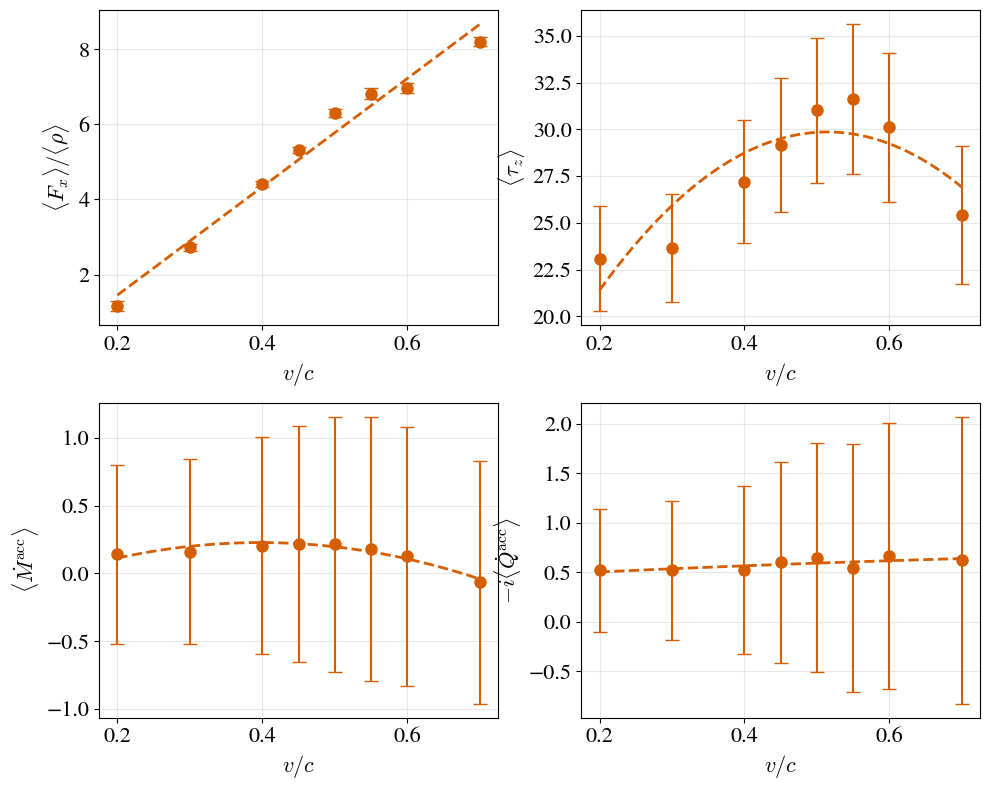

In [23]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define the threshold time for computing averages
t_threshold = 1000

tend_threshold = 5000

# Arrays to store velocity and computed values
velocities = []
fdrag_avg = []
fdrag_std = []
torque_avg = []
torque_std = []
macc_avg = []
macc_std = []
qacc_avg = []
qacc_std = []

# Use all available velocities from previous cells
simnames = [     
    (0.2, '20250630_ncell416_v02_mu005_r35'),
    (0.3, '20250630_ncell416_v03_mu005_r35'),
    (0.4, '20250630_ncell416_v04_mu005_r35'),
    (0.45, '20250702_ncell416_v045_mu005_r35'),
    (0.5, '20250630_ncell416_v05_mu005_r35'),
    (0.55, '20250702_ncell416_v055_mu005_r35'),
    (0.6, '20250702_ncell416_v06_mu005_r35'),
    (0.7, '20250702_ncell416_v07_mu005_r35')
    # (0.4, '20250630_ncell416_v04_mu005'),
    # # (0.45, '20250629_ncell320_v045_mu08'),
    # (0.5, '20250630_ncell416_v05_mu005'),
    # # (0.55, '20250629_ncell320_v055_mu08'),
    # (0.6, '20250630_ncell416_v06_mu005')
    # , (0.7, '20250630_ncell416_v07_mu005')
]

# Parameters needed for calculations
outR = 100.0  # Using the larger outR value
excise_factor = 1.5
average_rho_after = 1000
surface_factor_bbh = 1.0/np.pi
volume_factor_bbh_torque = 1.2  # For torque calculation
volume_factor_bbh_macc = 0.5    # For mass accretion calculation

# Process each velocity
for wave_vel, simname in simnames:
    print(f"Processing velocity {wave_vel}")
    
    try:
        # Load the data
        results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")
        results = results[1:]  # Remove first data point
        
        results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
        results_sur = results_sur[1:]

        # remove data after t=tend_threshold
        results = results[results[:,0]<=tend_threshold]
        results_sur = results_sur[results_sur[:,0]<=tend_threshold]
        
        dt = results[1,0] - results[0,0]
        window_size = int(T_orbit/dt)
        
        # Average density for normalization
        avgrho = np.mean(results_sur[:,10][results_sur[:,0]>average_rho_after])
        
        # 1. Drag Force calculation
        smoothed_drag = np.zeros_like(results[:,1])
        valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
        smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window
        
        normalized_drag = -smoothed_drag/avgrho
        
        # 2. Torque calculation
        smoothed_torque = np.zeros_like(results[:,0])
        valid_smoothed_torque = np.convolve(
            results[:,7]*volume_factor_bbh_torque - (results_sur[:,12] + results_sur[:,13])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_torque[window_size-1:window_size-1+len(valid_smoothed_torque)] = valid_smoothed_torque
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_torque[i] = np.sum(
                results[:curr_window,7]*volume_factor_bbh_torque - 
                (results_sur[:curr_window,12] + results_sur[:curr_window,13])*surface_factor_bbh
            ) / curr_window
        
        normalized_torque = smoothed_torque/avgrho
        
        # 3. Mass Accretion calculation
        smoothed_macc = np.zeros_like(results[:,0])
        valid_smoothed_macc = np.convolve(
            results[:,10]*volume_factor_bbh_macc - (results_sur[:,16] + results_sur[:,17])*surface_factor_bbh, 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_macc[window_size-1:window_size-1+len(valid_smoothed_macc)] = valid_smoothed_macc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_macc[i] = np.sum(
                results[:curr_window,10]*volume_factor_bbh_macc - 
                (results_sur[:curr_window,16] + results_sur[:curr_window,17])*surface_factor_bbh
            ) / curr_window
        
        normalized_macc = smoothed_macc/avgrho
        
        # 4. Charge Accretion calculation
        smoothed_qacc = np.zeros_like(results[:,0])
        valid_smoothed_qacc = np.convolve(
            (results_sur[:,18] + results_sur[:,19]), 
            np.ones(window_size)/window_size, 
            mode='valid'
        )
        smoothed_qacc[window_size-1:window_size-1+len(valid_smoothed_qacc)] = valid_smoothed_qacc
        
        for i in range(window_size-1):
            curr_window = i + 1
            smoothed_qacc[i] = np.sum(results_sur[:curr_window,18] + results_sur[:curr_window,19]) / curr_window
        
        normalized_qacc = -smoothed_qacc/avgrho
        
        # Calculate statistics for t > t_threshold
        mask = results[:,0] > t_threshold
        
        # Store velocity and computed statistics
        velocities.append(wave_vel)
        
        # Drag force
        fdrag_avg.append(np.mean(normalized_drag[mask]))
        fdrag_std.append(np.std(normalized_drag[mask]))
        
        # Torque
        torque_avg.append(np.mean(normalized_torque[mask]))
        torque_std.append(np.std(normalized_torque[mask]))
        
        # Mass accretion
        macc_avg.append(np.mean(normalized_macc[mask]))
        macc_std.append(np.std(normalized_macc[mask]))
        
        # Charge accretion
        qacc_avg.append(np.mean(normalized_qacc[mask]))
        qacc_std.append(np.std(normalized_qacc[mask]))
        
    except Exception as e:
        print(f"Error processing velocity {wave_vel}: {e}")

# Convert to numpy arrays for easier processing
velocities = np.array(velocities)
fdrag_avg = np.array(fdrag_avg)
fdrag_std = np.array(fdrag_std)
torque_avg = np.array(torque_avg)
torque_std = np.array(torque_std)
macc_avg = np.array(macc_avg)
macc_std = np.array(macc_std)
qacc_avg = np.array(qacc_avg)
qacc_std = np.array(qacc_std)

# Sort everything by velocity
sort_indices = np.argsort(velocities)
velocities = velocities[sort_indices]
fdrag_avg = fdrag_avg[sort_indices]
fdrag_std = fdrag_std[sort_indices]
torque_avg = torque_avg[sort_indices]
torque_std = torque_std[sort_indices]
macc_avg = macc_avg[sort_indices]
macc_std = macc_std[sort_indices]
qacc_avg = qacc_avg[sort_indices]
qacc_std = qacc_std[sort_indices]

# Create 2x2 panel plot - smaller size to make text relatively bigger
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, figure=fig)

color = color_mu005

# 1. Drag Force vs Velocity
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(velocities, fdrag_avg, yerr=fdrag_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for drag force using all data points
fdrag_fit = np.polyfit(velocities, fdrag_avg, 1)
x_fit_fdrag = np.linspace(min(velocities), max(velocities), 100)
fdrag_curve = np.polyval(fdrag_fit, x_fit_fdrag)
ax1.plot(x_fit_fdrag, fdrag_curve, '--', linewidth=2, color=color)

ax1.set_xlabel('$v/c$', fontsize=16)
ax1.set_ylabel('$\\langle F_x \\rangle/\\langle \\rho \\rangle$', fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=16)

# 2. Torque vs Velocity
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(velocities, torque_avg, yerr=torque_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for torque
torque_fit = np.polyfit(velocities, torque_avg, 2)
x_fit = np.linspace(min(velocities), max(velocities), 100)
torque_curve = np.polyval(torque_fit, x_fit)
ax2.plot(x_fit, torque_curve, '--', linewidth=2, color=color)

ax2.set_xlabel('$v/c$', fontsize=16)
ax2.set_ylabel('$\\langle \\tau_z \\rangle$', fontsize=16)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=16)

# 3. Mass Accretion vs Velocity
ax3 = fig.add_subplot(gs[1, 0])
ax3.errorbar(velocities, macc_avg, yerr=macc_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for mass accretion
macc_fit = np.polyfit(velocities, macc_avg, 2)
macc_curve = np.polyval(macc_fit, x_fit)
ax3.plot(x_fit, macc_curve, '--', linewidth=2, color=color)

ax3.set_xlabel('$v/c$', fontsize=16)
ax3.set_ylabel('$\\langle \\dot{M}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=16)

# 4. Charge Accretion vs Velocity
ax4 = fig.add_subplot(gs[1, 1])
ax4.errorbar(velocities, qacc_avg, yerr=qacc_std, fmt='o', capsize=5, markersize=8, color=color)

# Add quadratic fit for charge accretion
qacc_fit = np.polyfit(velocities, qacc_avg, 2)
qacc_curve = np.polyval(qacc_fit, x_fit)
ax4.plot(x_fit, qacc_curve, '--', linewidth=2, color=color)

ax4.set_xlabel('$v/c$', fontsize=16)
ax4.set_ylabel('$-i\\langle \\dot{Q}^{\\mathrm{acc}} \\rangle$', fontsize=16)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig("quantities_vs_velocity_mu005.pdf", bbox_inches='tight')

# Print the computed values for reference
print("\nComputed Statistics (average ± std):")
print("Velocity | Drag Force | Torque | Mass Accretion | Charge Accretion")
print("-" * 75)
for i, v in enumerate(velocities):
    print(f"{v:.2f} | {fdrag_avg[i]:.4f} ± {fdrag_std[i]:.4f} | {torque_avg[i]:.4f} ± {torque_std[i]:.4f} | {macc_avg[i]:.4f} ± {macc_std[i]:.4f} | {qacc_avg[i]:.4f} ± {qacc_std[i]:.4f}")
